In [2]:
from scipy.ndimage.filters import convolve

In [2]:
%run netCDF_Processing.py

In [3]:
cdf = CDFData(hgt_path = "E:\hgt.2012.nc",
              uwind_path = r"E:\uwnd.2012.nc",
              vwind_path = r"E:\vwnd.2012.nc")

INFO:root: 00:10:49 - Retrieved 2012 hgt data
INFO:root: 00:10:54 - Retrieved 2012 uwnd data
INFO:root: 00:10:59 - Retrieved 2012 vwnd data


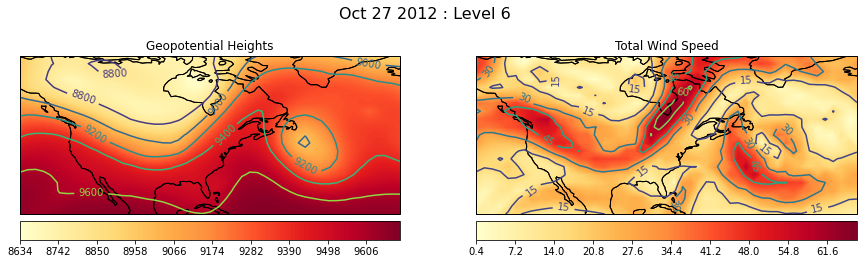

In [233]:
cdf.plot('all',(10,27),6,figsize=(15,4))
plt.show()

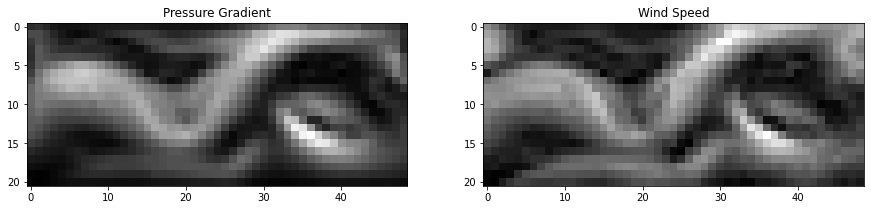

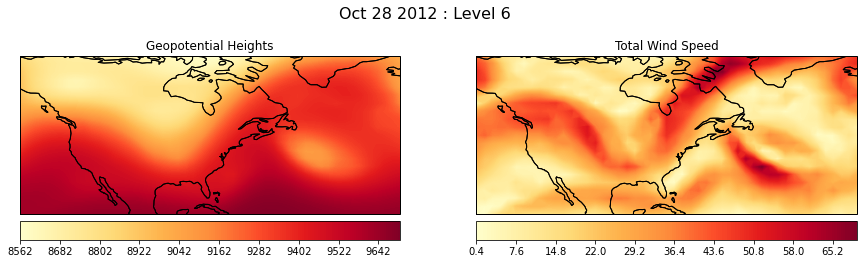

In [680]:
day = cdf.date_to_day((10,28))
level = 6
winds = cdf.loc_winds[day-1,level-1,...]
hgts = cdf.loc_hgts[day-1,level-1,...]

x_grad_kernel = np.array([[-1,0,1]])
y_grad_kernel = x_grad_kernel.reshape(-1,1)

x_grad = convolve(hgts,x_grad_kernel)
y_grad = convolve(hgts,y_grad_kernel)

grad = np.sqrt(np.square(x_grad) + np.square(y_grad))

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(grad,cmap='gist_gray')
ax[0].set_title('Pressure Gradient')
ax[1].imshow(winds,cmap='gist_gray')
ax[1].set_title('Wind Speed')
cdf.plot('all',day,level, contours=0)
plt.show()

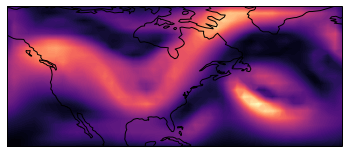

In [681]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.contourf(cdf.loc_lons, cdf.loc_lats,grad,cmap='magma', levels=100)

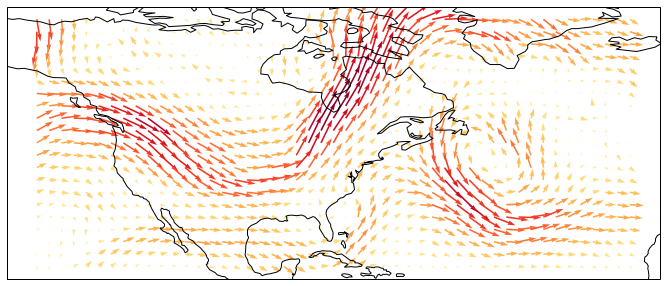

In [682]:
fig, ax = cdf.quiver((10,27),6)

# Masking

In [7]:
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import gaussian

Match Score: 47.61%


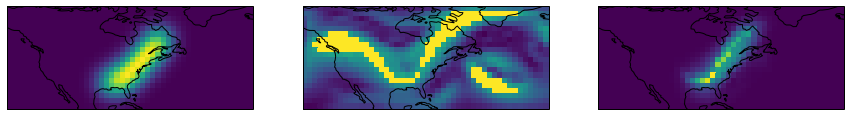

In [749]:
mask_img = imread(r"C:/Users/Administrator/Downloads/little_further_inward.png", as_gray=True)
mask_img = resize(mask_img,hgts.shape)
mask_img = normalize(gaussian(mask_img,sigma=2))
# mask_img[mask_img < mask_img.max()/10] = 0

fig, (ax1,ax2,ax3) = plt.subplots(1,3, subplot_kw={'projection':ccrs.PlateCarree()},figsize=(15,5))
ax1.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img)
ax1.coastlines()

thresh = 0.6
thresh_grad = normalize(grad.copy())
thresh_grad[thresh_grad > thresh] = 1
masked_grad = mask_img*thresh_grad

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,thresh_grad)
ax2.coastlines()

ax3.pcolor(cdf.loc_lons, cdf.loc_lats,masked_grad)
ax3.coastlines()

score = masked_grad.sum()/mask_img.sum()
print(f'Match Score: {round(score*100,2)}%')

In [723]:
def get_score(hgts,thresh=0):
    grad = gradient(hgts)
    masked_grad = mask_img*normalize(grad)
    
    if thresh:
        thresh_grad = normalize(grad.copy())
        thresh_grad[thresh_grad > thresh] = 1
        masked_grad = mask_img*thresh_grad
    
    score1 = masked_grad.sum()/mask_img.sum()

    return score1

In [750]:
level = 5
thresh = 0.6

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    hgts = cdf.loc_hgts[day-1,level-1,...]
    scores[day] = get_score(hgts,thresh=thresh)

arg_scores = np.argsort(scores)

Score: 67.85%


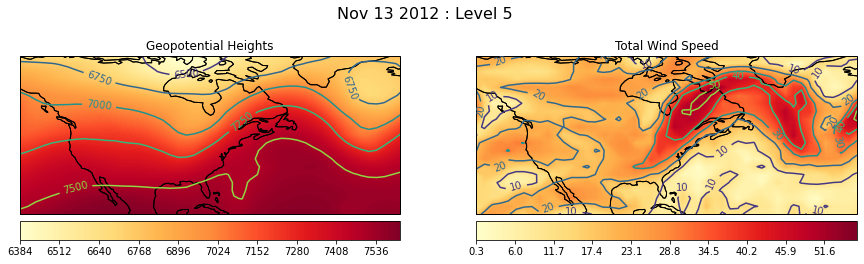

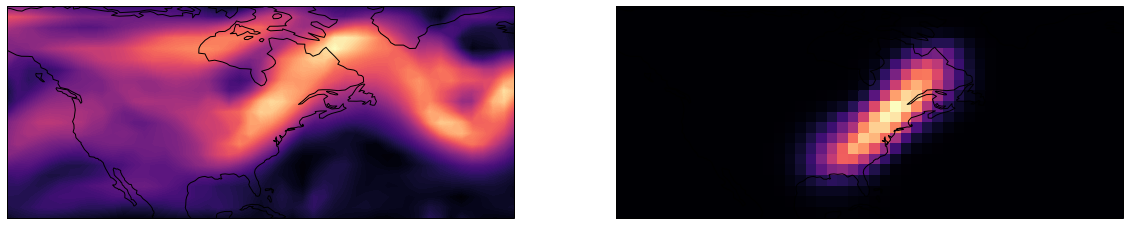

In [753]:
n = 2
cdf.plot('all',int(arg_scores[-n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {round(scores[arg_scores[-n]]*100,2)}%')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

# Top 10 Results

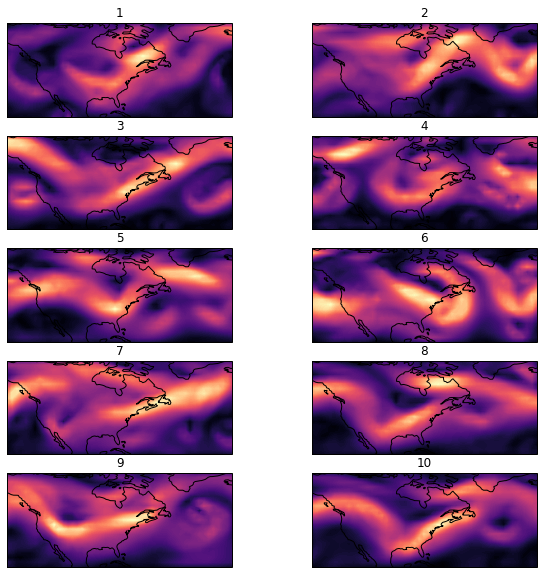

In [754]:
fig, axes = plt.subplots(5,2, figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
for n in range(1,11):
    
    cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    ax = axes.ravel()[n-1]
    ax.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)
    ax.coastlines()
    ax.set_title(n)

# Using Wind Data

(<Figure size 864x360 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x215ee90fa08>)

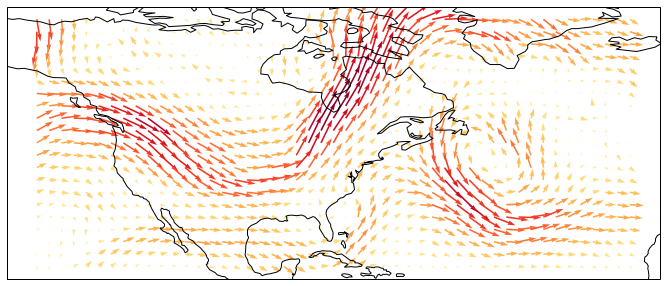

In [779]:
level = 6
ref_day = cdf.date_to_day((10,27))

# cdf.localize(lat0=30,lat1=70,lon0=-90,lon1=-65)

cdf.localize()
u_winds = cdf.loc_u_winds[ref_day-1,level-1,...]
u_winds = (u_winds/cdf.loc_winds[ref_day-1,level-1,...])*mask_img
v_winds = cdf.loc_v_winds[ref_day-1,level-1,...]
v_winds = (v_winds/cdf.loc_winds[ref_day-1,level-1,...])*mask_img
cdf.quiver((10,27), 6)

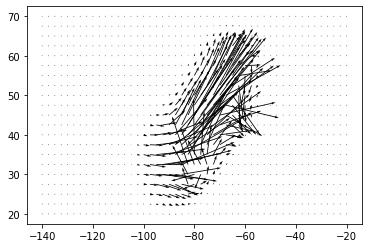

In [780]:
plt.quiver(cdf.loc_lons,cdf.loc_lats,u_winds,v_winds)

In [857]:
def match_score(u_wnd,v_wnd):
    wnd = np.sqrt(np.square(u_wnd) + np.square(u_wnd))
    
    u_comp = normalize(u_wnd)*u_winds
    v_comp = normalize(v_wnd)*v_winds
    
    return np.sqrt(np.square(u_comp) + np.square(u_comp)).sum()

In [858]:
level = 6

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    u_wnds = cdf.loc_u_winds[day-1,level-1,...]
    v_wnds = cdf.loc_v_winds[day-1,level-1,...]
    
    scores[day] = match_score(u_wnds,v_wnds)

arg_scores = np.argsort(scores)

Score: 0.053642794534028405


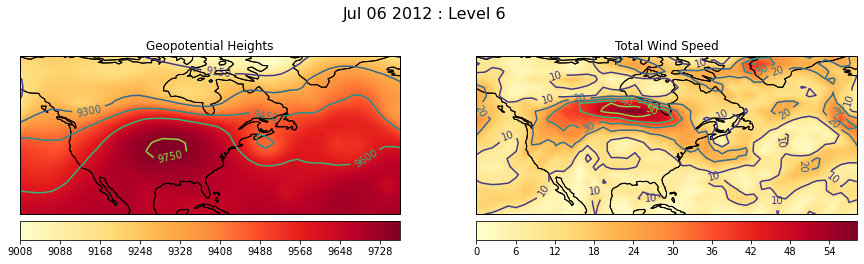

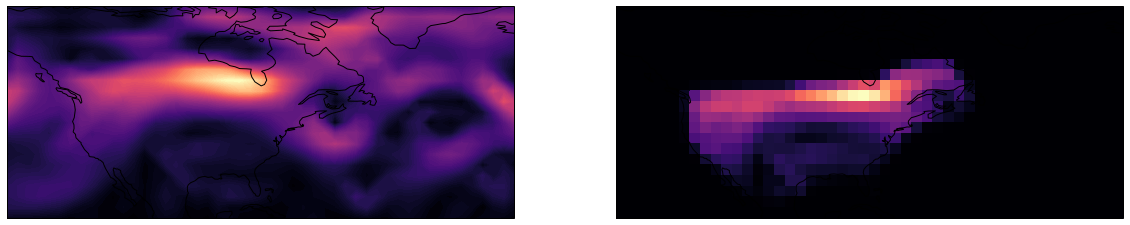

In [859]:
n = 1

cdf.plot('all',int(arg_scores[-n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[-n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

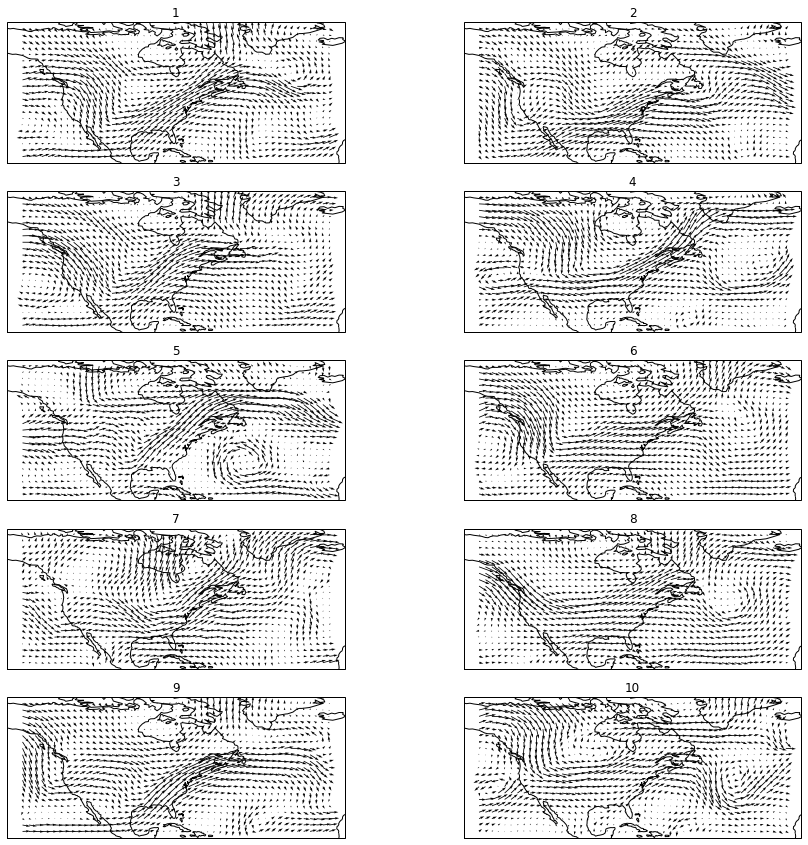

In [831]:
fig, axes = plt.subplots(5,2, figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})
for n in range(1,11):
    
    cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    cur_uwinds = cdf.loc_u_winds[arg_scores[-n]-1,level-1,...]
    cur_vwinds = cdf.loc_v_winds[arg_scores[-n]-1,level-1,...]
    
    ax = axes.ravel()[n-1]
#     ax.contourf(cdf.loc_lons, cdf.loc_lats, cur_grad, cmap='magma', levels=100)
    ax.quiver(cdf.loc_lons,cdf.loc_lats,cur_uwinds,cur_vwinds)
    ax.coastlines()
    ax.set_title(n)

### Try Vector Mask

In [35]:
mask_img = imread(r"C:/Users/Administrator/Downloads/continental_US_mask.png", as_gray=True)
mask_img = resize(mask_img,cdf.loc_hgts.shape[1,1,...])
# mask_img = normalize(gaussian(mask_img,sigma=1))

TypeError: tuple indices must be integers or slices, not tuple

TypeError: Invalid shape (366, 12, 21, 49) for image data

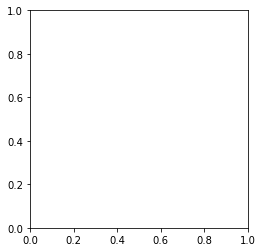

In [33]:
plt.imshow(mask_img)

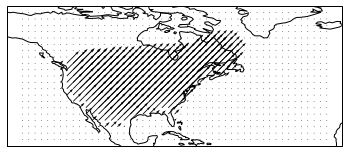

In [843]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
# u = mask_img*np.cos(np.deg2rad(45))
# v = mask_img*np.cos(np.deg2rad(45))
# u = np.roll(u,-3)
# v = np.roll(v,-3)
ax.quiver(cdf.loc_lons, cdf.loc_lats, u,v)
ax.coastlines()

In [864]:
'''
def match_score(u_wnd,v_wnd):
    u_comp = normalize(u_wnd)*u
    v_comp = normalize(v_wnd)*v
    return u_comp.sum() + v_comp.sum()
'''
def match_score(uwnd,vwnd):
    day = cdf.date_to_day((10,28))
    level = 6
    uwnd = normalize(uwnd*mask_img)
    vwnd = normalize(vwnd*mask_img)
    
    loc_u_wind = normalize(cdf.loc_u_winds[day-1,level-1,...])*mask_img
    loc_v_wind = normalize(cdf.loc_v_winds[day-1,level-1,...])*mask_img
    u_comp = loc_u_wind - uwnd
    v_comp = loc_v_wind - vwnd
    
    return (np.sqrt(np.square(u_comp) + np.square(v_comp)).sum())

level = 6

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    u_wnds = cdf.loc_u_winds[day-1,level-1,...]
    v_wnds = cdf.loc_v_winds[day-1,level-1,...]
    
    scores[day] = match_score(u_wnds,v_wnds)

arg_scores = np.argsort(scores)

Score: 715.1471778203563


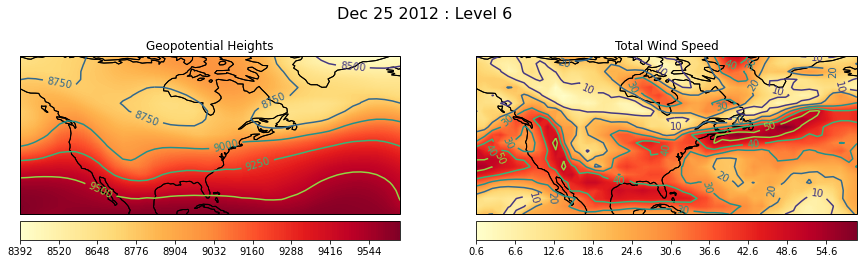

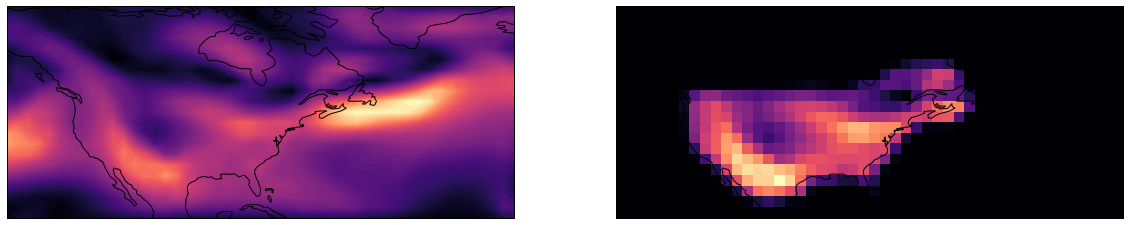

In [865]:
n = 1
cdf.plot('all',int(arg_scores[-n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[-n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

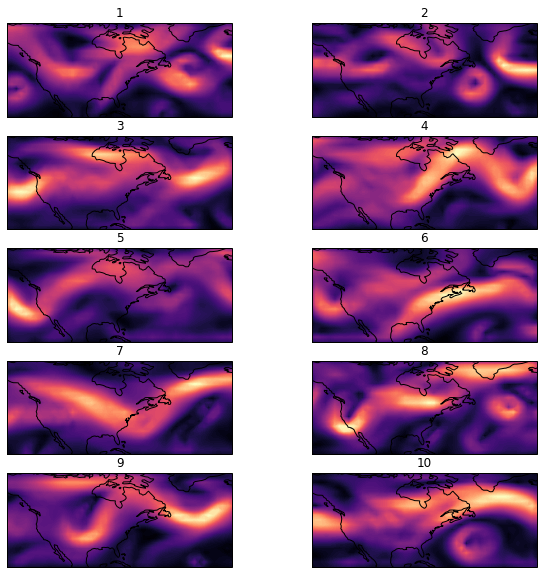

In [853]:
fig, axes = plt.subplots(5,2, figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})

for n in range(1,11):
    
    cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    ax = axes.ravel()[n-1]
    ax.contourf(cdf.loc_lons, cdf.loc_lats, cur_grad, cmap='magma', levels=100)
    ax.coastlines()
    ax.set_title(n)

# Match Similarity to Oct 28

In [36]:
level = 6
day = cdf.date_to_day((10,28))

mask_img = imread(r"C:/Users/Administrator/Downloads/continental_US_mask.png", as_gray=True)
mask_img = resize(mask_img,cdf.loc_hgts[day-1,level-1].shape)

loc_u_winds = normalize(cdf.loc_u_winds[day-1,level-1,...]*mask_img)
loc_v_winds = normalize(cdf.loc_v_winds[day-1,level-1,...]*mask_img)

def match_score(uwnd,vwnd):
    # Higher score is worse
    uwnd = normalize(uwnd*mask_img)
    vwnd = normalize(vwnd*mask_img)
    diff = np.sqrt(np.square(uwnd-loc_u_winds)+np.square(vwnd-loc_v_winds))
    masked_diff = diff*mask_img
    
    return masked_diff.sum()

In [37]:
cur_day = cdf.date_to_day((10,28))
cur_uwnd = cdf.loc_u_winds[cur_day-1,level-1,...]
cur_vwnd = cdf.loc_v_winds[cur_day-1,level-1,...]

print(match_score(cur_uwnd,cur_vwnd)) # Match between oct 28 and oct 28 is 0 -> perfect match obviously

0.0


In [38]:
scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

levels = [5,6,7,8]
for day in days:
    for lvl in levels:
        u_wnds = cdf.loc_u_winds[day-1,lvl-1,...]
        v_wnds = cdf.loc_v_winds[day-1,lvl-1,...]
    
        scores[day] += match_score(u_wnds,v_wnds)

arg_scores = np.argsort(scores)

Score: 191.6748250453793


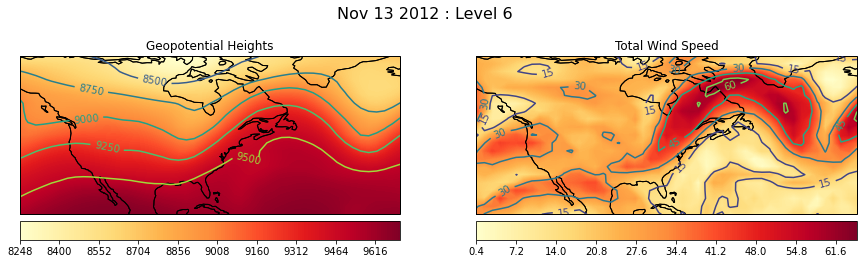

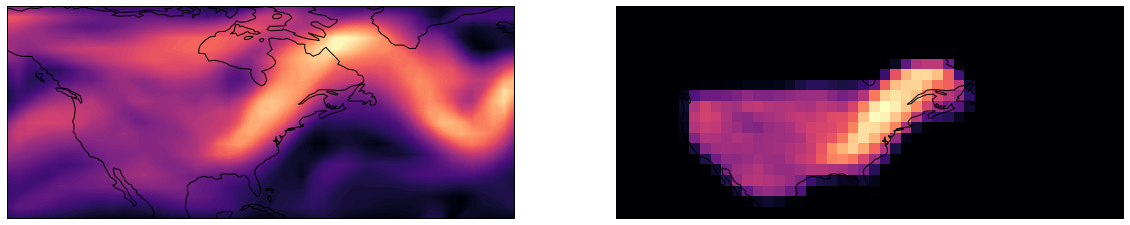

In [42]:
n = 4
cdf.plot('all',int(arg_scores[n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

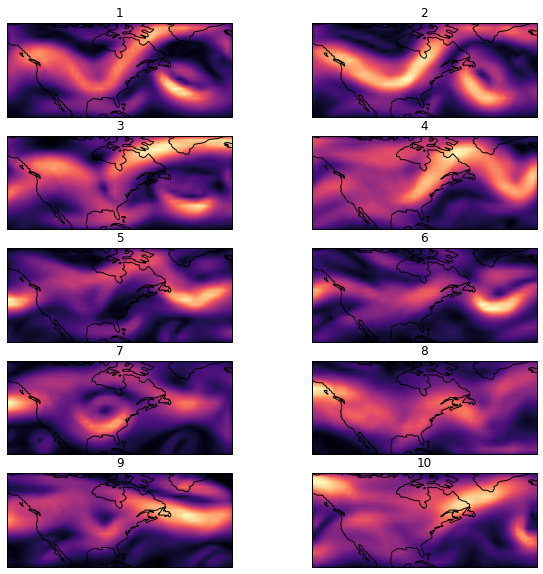

In [17]:
fig, axes = plt.subplots(5,2, figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})

for n in range(10):
    
    cur_hgts = cdf.loc_hgts[arg_scores[n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    ax = axes.ravel()[n]
    ax.contourf(cdf.loc_lons, cdf.loc_lats, cur_grad, cmap='magma', levels=100)
    ax.coastlines()
    ax.set_title(n+1)

# Extended US Mask

In [43]:
level = 7
day = cdf.date_to_day((10,28))

mask_img = imread(r"C:/Users/Administrator/Downloads/extended_US_mask.png", as_gray=True)
mask_img = resize(mask_img,cdf.loc_hgts[day-1,level-1].shape)

loc_u_winds = normalize(cdf.loc_u_winds[day-1,level-1,...]*mask_img)
loc_v_winds = normalize(cdf.loc_v_winds[day-1,level-1,...]*mask_img)

def match_score(uwnd,vwnd):
    # Higher score is worse
    uwnd = normalize(uwnd*mask_img)
    vwnd = normalize(vwnd*mask_img)
    diff = np.sqrt(np.square(uwnd-loc_u_winds)+np.square(vwnd-loc_v_winds))
    masked_diff = diff*mask_img
    
    return masked_diff.sum()

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

levels = [5,6,7,8]
for day in days:
    for lvl in levels:
        u_wnds = cdf.loc_u_winds[day-1,lvl-1,...]
        v_wnds = cdf.loc_v_winds[day-1,lvl-1,...]
    
        scores[day] += match_score(u_wnds,v_wnds)

arg_scores = np.argsort(scores)

Score: 330.9604733639167


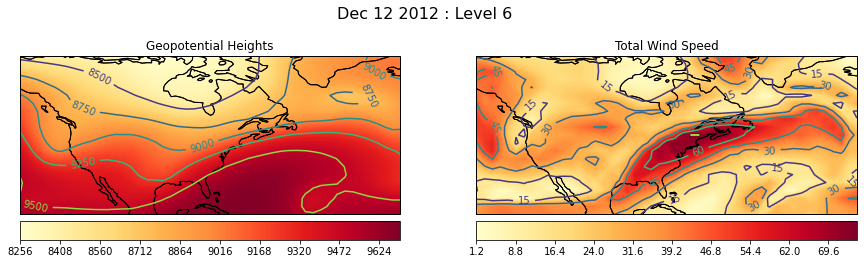

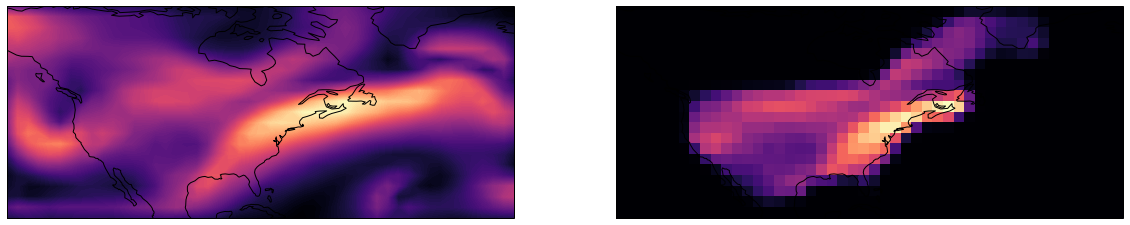

In [70]:
n = 50
cdf.plot('all',int(arg_scores[n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

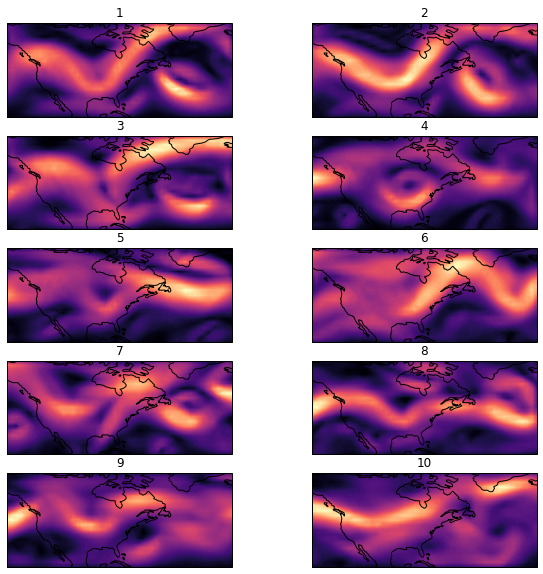

In [26]:
fig, axes = plt.subplots(5,2, figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})

for n in range(10):
    
    cur_hgts = cdf.loc_hgts[arg_scores[n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    ax = axes.ravel()[n]
    ax.contourf(cdf.loc_lons, cdf.loc_lats, cur_grad, cmap='magma', levels=100)
    ax.coastlines()
    ax.set_title(n+1)

In [56]:
day = cdf.date_to_day((10,19))
level = 6

hgts = cdf.loc_hgts[day-1, level-1]
grad = gradient(hgts)

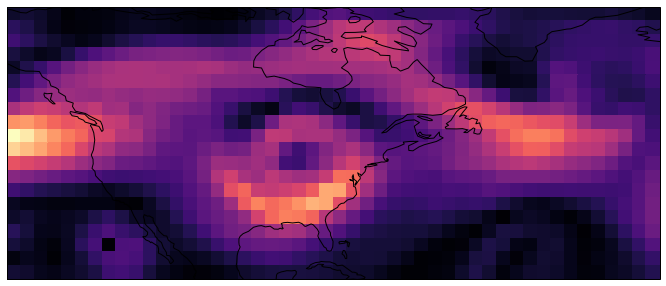

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12,5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.pcolor(cdf.loc_lons,cdf.loc_lats, grad, cmap='magma')
ax.coastlines()

# Mask to High Continental Pressure Gradient

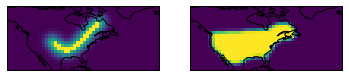

In [144]:
mask_img = imread(r"C:/Users/Administrator/Downloads/shorter_tail.png", as_gray=True)
US_mask = imread(r"C:/Users/Administrator/Downloads/continental_US_mask.png", as_gray=True)
US_mask = resize(US_mask,cdf.loc_hgts[day-1,level-1].shape)
gauss_std = 1.2
thresh = 0.7
mask_img = resize(mask_img,cdf.loc_hgts[day-1,level-1].shape)
mask_img = gaussian(mask_img,gauss_std)
mask_img[mask_img >= thresh] = 1

fig, axes = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()})

axes[0].pcolor(cdf.loc_lons,cdf.loc_lats,mask_img)
axes[0].coastlines()

axes[1].pcolor(cdf.loc_lons,cdf.loc_lats,US_mask)
axes[1].coastlines()
plt.show()

In [145]:
level = 6
ref_day = cdf.date_to_day((10,28))
test_day = cdf.date_to_day((10,27))

# Mask ONLY ref values to high gradient contour
        # High gradients outside of this area are penalized
ref_u_winds = normalize(cdf.loc_u_winds[ref_day-1,level-1]*US_mask)*mask_img
ref_v_winds = normalize(cdf.loc_v_winds[ref_day-1,level-1]*US_mask)*mask_img

# Normalize to Continental US
test_u_winds = normalize(cdf.loc_u_winds[test_day-1,level-1]*US_mask)
test_v_winds = normalize(cdf.loc_v_winds[test_day-1,level-1]*US_mask)

def match_score(t_u, t_v, r_u, r_v):
    # Factor in gradient strength somehow?
    score = np.sqrt(np.square(r_u-t_u)+np.square(r_v-t_v)).sum()
    return score

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    
    test_u_winds = normalize(cdf.loc_u_winds[day-1,level-1].copy()*US_mask)*mask_img # *mask_img because omitting it wasn't working
    test_v_winds = normalize(cdf.loc_v_winds[day-1,level-1].copy()*US_mask)*mask_img

    scores[day] += match_score(test_u_winds, test_v_winds, ref_u_winds, ref_v_winds)

arg_scores = np.argsort(scores)

Score: 18.443585897233238


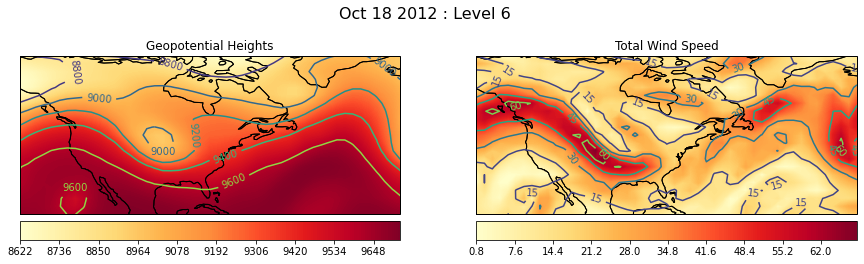

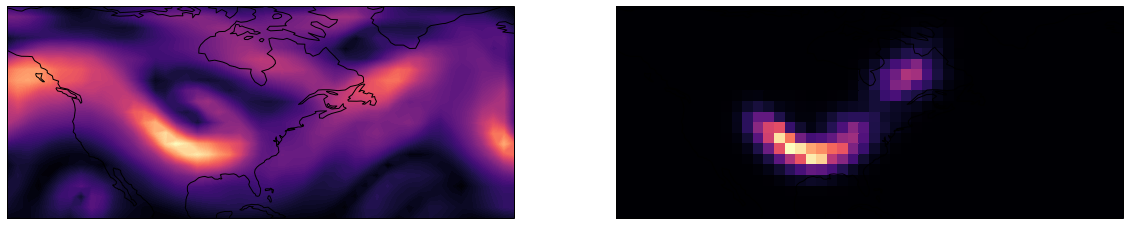

In [155]:
n = 9
cdf.plot('all',int(arg_scores[n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

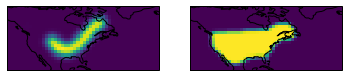

In [12]:
mask_path = r"C:\Users\Administrator\Downloads\shorter_tail.png"
US_mask = imread(r"C:/Users/Administrator/Downloads/continental_US_mask.png", as_gray=True)
US_mask = resize(US_mask,(21,49))
mask_img = resize(imread(mask_path, as_gray=True),(21,49))
mask_img = gaussian(mask_img,1)

fig, axes = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()})

axes[0].pcolor(cdf.loc_lons,cdf.loc_lats,mask_img)
axes[0].coastlines()

axes[1].pcolor(cdf.loc_lons,cdf.loc_lats,US_mask)
axes[1].coastlines()
plt.show()

(<Figure size 1080x288 with 4 Axes>,
 array([<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x00000175A5F9A988>,
       dtype=object))

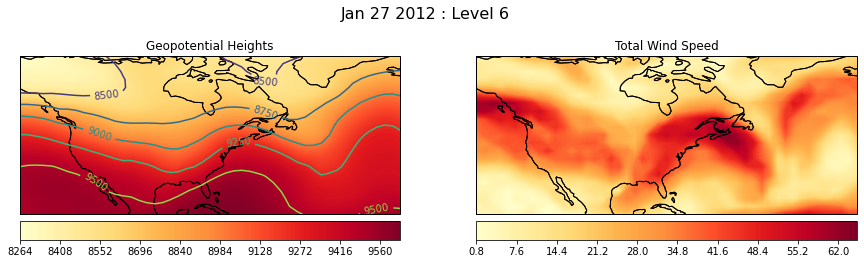

In [13]:
cdf.plot('all',27,6)

# Weighted Levels

In [17]:
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import gaussian
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import netCDF4 as nc
import cftime as cft
import logging
import datetime
import pandas as pd
logging.getLogger().setLevel(logging.INFO)
%run netCDF_Processing.py

In [50]:
DATA_ROOT = r"E:\WeatherData"

ref_date = (2012,10,28)

ref_u_winds_path = r"E:\WeatherData\u_winds\uwnd.2012.nc"
ref_v_winds_path = r"E:\WeatherData\v_winds\vwnd.2012.nc"
mask_path = r"C:\Users\Administrator\Downloads\continental_US_mask.png"

lon0 = 220
lon1 = 340
lat0 = 20
lat1 = 70

ref_u = retrieve_loc_data(ref_u_winds_path,lon0,lon1,lat0,lat1)[date_to_day(ref_date)-1]
ref_v = retrieve_loc_data(ref_v_winds_path,lon0,lon1,lat0,lat1)[date_to_day(ref_date)-1]
mask_img = resize(imread(mask_path, as_gray=True),ref_u.shape[-2:])
# mask_img = gaussian(mask_img,1)

In [52]:
def retrieve_loc_data(path, lon0, lon1, lat0, lat1, return_times=False):
    
    fh = Dataset(path, mode='r')
    lons = fh.variables['lon'][:].data
    lats = fh.variables['lat'][:].data
    
    if 'uwnd' in path:
        name = 'uwnd'
    else:
        name = 'vwnd'
    
    data = fh.variables[name][:].data
    
    times = fh.variables['time'][:].data
    times = cft.num2pydate(times, fh.variables['time'].units, calendar='standard')
                
    lat_mask = ((lats >= lat0) & (lats <= lat1))

    lon_mask = ((lons >= lon0) & (lons <= lon1))

    start_lat = np.argwhere(lat_mask).min()
    end_lat = np.argwhere(lat_mask).max()

    start_lon = np.argwhere(lon_mask).min()
    end_lon = np.argwhere(lon_mask).max()

    loc_data = data[..., start_lat:end_lat+1, start_lon:end_lon+1]
    
    if return_times:
        return times, loc_data
    
    return loc_data


def get_score(u, v, r_u, r_v, mask):
    u = u[:]*mask
    u = normalize(u[:])
    v = v[:]*mask
    v = normalize(v[:])
    r_u = r_u[:]*mask
    r_u = normalize(r_u[:])
    r_v = r_v[:]*mask
    r_v = normalize(r_v[:])
    
    diff = np.sqrt(np.square(r_u-u) + np.square(r_v-v))/np.sqrt(2)
    
    # without cube, scores were generally too high
        # Increase score spread in range [0,1]
    return np.power(1-diff.mean(),4)

In [53]:
#scores = {year1:[day1_score, day2_score, day3_score, ...]}
scores = []

start_year = 1979
end_year = 2020 + 1

levels = [5,6,7]
level_weights = [0.25, 0.5, 0.25]

# for year in years:
for year in range(start_year, end_year):

    uwnd_path = os.path.join(DATA_ROOT,"u_winds",f'uwnd.{year}.nc')
    vwnd_path = os.path.join(DATA_ROOT,"v_winds",f'vwnd.{year}.nc')
    # retrieve data
    try:
        times, uwnds = retrieve_loc_data(uwnd_path,lon0,lon1,lat0,lat1, return_times=True)
        vwnds = retrieve_loc_data(vwnd_path,lon0,lon1,lat0,lat1)
    except:
        logging.info(f'Insufficient Data found for {year}')
        continue
    
    
    # for day in range(days):
    for day in range(uwnds.shape[0]):
        
        score = 0
        for i,level in enumerate(levels):
            cur_u_winds = uwnds[day, level-1]
            cur_v_winds = vwnds[day, level-1]
            
            # scores[year].append(get_score(day))
            score += get_score(cur_u_winds, cur_v_winds, ref_u[level-1], ref_v[level-1], mask_img)*level_weights[i]
        
        time = times[day]
        scores.append([time,score])
       
    time_now = datetime.datetime.now().strftime(r"%H:%M:%S")
    logging.info(f'  {time_now}  -  Year {year} Complete')

INFO:root:  23:12:16  -  Year 1979 Complete
INFO:root:  23:12:26  -  Year 1980 Complete
INFO:root:  23:12:35  -  Year 1981 Complete
INFO:root:  23:12:43  -  Year 1982 Complete
INFO:root:  23:12:52  -  Year 1983 Complete
INFO:root:  23:13:00  -  Year 1984 Complete
INFO:root:  23:13:09  -  Year 1985 Complete
INFO:root:  23:13:17  -  Year 1986 Complete
INFO:root:  23:13:26  -  Year 1987 Complete
INFO:root:  23:13:34  -  Year 1988 Complete
INFO:root:  23:13:43  -  Year 1989 Complete
INFO:root:  23:13:51  -  Year 1990 Complete
INFO:root:  23:14:00  -  Year 1991 Complete
INFO:root:  23:14:09  -  Year 1992 Complete
INFO:root:  23:14:17  -  Year 1993 Complete
INFO:root:  23:14:26  -  Year 1994 Complete
INFO:root:  23:14:34  -  Year 1995 Complete
INFO:root:  23:14:43  -  Year 1996 Complete
INFO:root:  23:14:51  -  Year 1997 Complete
INFO:root:  23:15:00  -  Year 1998 Complete
INFO:root:  23:15:08  -  Year 1999 Complete
INFO:root:  23:15:17  -  Year 2000 Complete
INFO:root:  23:15:26  -  Year 20

In [54]:
df = pd.DataFrame(scores, columns = ['date','score'])
df.head()

date     score
0 1979-01-01  0.521131
1 1979-01-02  0.540779
2 1979-01-03  0.462414
3 1979-01-04  0.420467
4 1979-01-05  0.497197

In [55]:
time = datetime.datetime.now().strftime(r"%b %d - %H %M %S")
df.to_csv('scores_weighted_levels.csv')
# df.to_csv(f'scores {time}.csv', index=False)

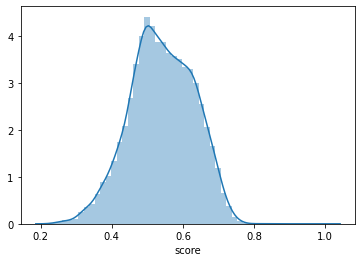

In [56]:
import seaborn as sns
sns.distplot(df['score'])

In [57]:
df.sort_values('score', ascending=False).head(10)

date     score
12354 2012-10-28  1.000000
6144  1995-10-28  0.823191
2458  1985-09-24  0.794891
7483  1999-06-28  0.776101
9617  2005-05-01  0.773384
11949 2011-09-19  0.765506
5863  1995-01-20  0.765096
9254  2004-05-03  0.764799
1628  1983-06-17  0.763951
9832  2005-12-02  0.762478

In [61]:
cdf = CDFData(hgt_path = r"E:\WeatherData\hgts\hgt.1999.nc",
              uwind_path = r"E:\WeatherData\u_winds\uwnd.1999.nc",
              vwind_path = r"E:\WeatherData\v_winds\vwnd.1999.nc")

INFO:root: 23:19:44 - Retrieved 1999 hgt data
INFO:root: 23:19:48 - Retrieved 1999 uwnd data
INFO:root: 23:19:53 - Retrieved 1999 vwnd data


(<Figure size 1080x288 with 4 Axes>,
 array([<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x000001758534B748>,
       dtype=object))

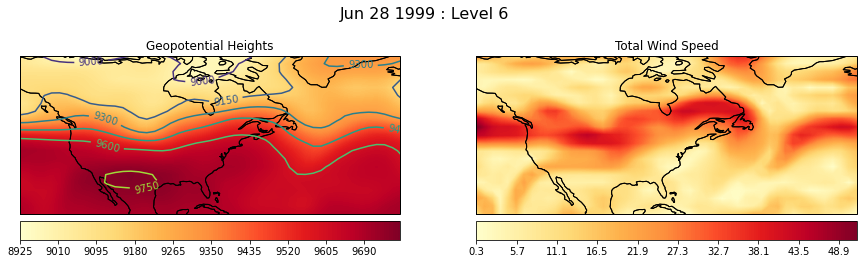

In [62]:
cdf.plot('all',(6,28),6)

(<Figure size 864x360 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x175858c2448>)

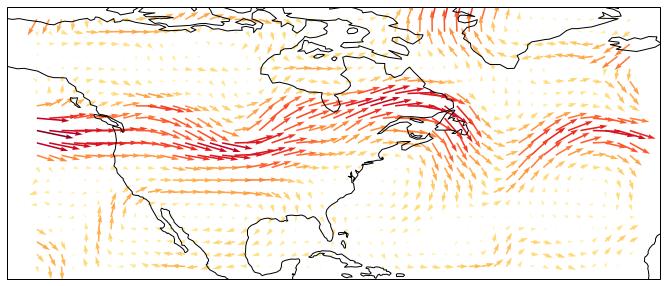

In [63]:
cdf.quiver((6,28),6)

In [44]:
cdf = CDFData(hgt_path = r"E:\WeatherData\hgts\hgt.1995.nc",
              uwind_path = r"E:\WeatherData\u_winds\uwnd.1995.nc",
              vwind_path = r"E:\WeatherData\v_winds\vwnd.1995.nc")

INFO:root: 23:05:22 - Retrieved 1995 hgt data
INFO:root: 23:05:27 - Retrieved 1995 uwnd data
INFO:root: 23:05:32 - Retrieved 1995 vwnd data


(<Figure size 1080x288 with 4 Axes>,
 array([<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x0000017584CAFD08>,
       dtype=object))

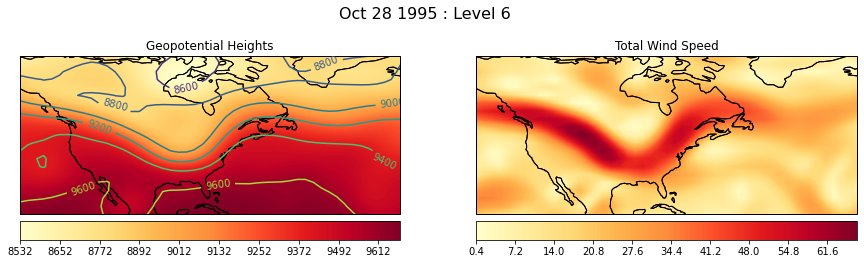

In [45]:
cdf.plot('all',(10,28),6)

In [46]:
u = cdf.loc_u_winds[cdf.date_to_day((10,21)),6-1]
v = cdf.loc_v_winds[cdf.date_to_day((10,21)),6-1]
get_score(u,v,ref_u[level-1], ref_v[level-1], mask_img)

0.671547522167473